<a href="https://colab.research.google.com/github/Karthick47v2/speech-emotion-classifier/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_mfcc =np.load('drive/MyDrive/SER/X_mfcc_2048.npy')
X_mel = np.load('drive/MyDrive/SER/X_mel_2048.npy')
y = np.load('drive/MyDrive/SER/y_2048.npy')

In [ ]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_mel, y_encoded, random_state=42, test_size=0.1)
x_test, x_T_test, y_test, y_T_test = train_test_split(x_test, y_test, random_state=42, test_size=0.25)

In [ ]:
x_test.shape

In [ ]:
n_rows = x_train.shape[1]
n_cols = x_train.shape[2]
n_channels = 1

x_train = x_train.reshape(x_train.shape[0], n_rows, n_cols, n_channels)
x_test = x_test.reshape(x_test.shape[0], n_rows, n_cols, n_channels)

In [ ]:
# # MEL - 300 EPOCHS

model.add(keras.layers.Conv2D(filters=16, kernel_size=(5,5), kernel_initializer="he_normal", input_shape=(n_rows, n_cols, n_channels), activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(6,6)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(6,6)))

model.add(keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())


model.add(keras.layers.Dropout(0.7))

model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(units=7, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=2e-4)) # 2

model.summary()
n_epochs = 300
batch_size = 32

checkpoint = keras.callbacks.ModelCheckpoint(filepath='mel-model', 
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[checkpoint], verbose=1)

In [ ]:
## MFCC
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer="he_normal", input_shape=(n_rows, n_cols, n_channels), activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))  # 32
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(units=7, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.5e-4)) # 1e-4 ###### 0.5e-4

n_epochs = 600 
batch_size = 16

checkpoint = keras.callbacks.ModelCheckpoint(filepath='mel-model', 
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

lr_shed = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1, patience=10, factor=0.99, min_lr=1e-7) # 77 70

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[checkpoint, lr_shed], verbose=1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
! unzip model1.zip
! unzip model2.zip

In [ ]:
# test
model1 = keras.models.load_model('mel-model1')
model2 = keras.models.load_model('mel-model2')

x_train, x_test, y_train, y_test = train_test_split(X_mel, y_encoded, random_state=42, test_size=0.2)
x_test, x_MEL_test, y_test, y_MEL_test = train_test_split(x_test, y_test, random_state=42, test_size=0.25)

453
0.8896247240618101
0.8905227045730847


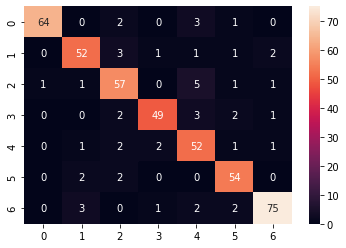

In [ ]:
y_preds = model1.predict(x_T_test)
y_hat = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_T_test, axis=1)

cm = confusion_matrix(y_true, y_hat)

sum = 0

for i in range(cm.shape[0]):
  sum += cm[i,i]

print(len(y_preds))
print(sum / len(y_preds))
print(f1_score(y_true, y_hat, average='weighted'))
sns.heatmap(cm, annot=True)

In [ ]:
! unzip model3.zip
! unzip model4.zip

Archive:  model3.zip
   creating: MFCC_MODEL_1_86_85/
  inflating: MFCC_MODEL_1_86_85/keras_metadata.pb  
  inflating: MFCC_MODEL_1_86_85/saved_model.pb  
   creating: MFCC_MODEL_1_86_85/assets/
   creating: MFCC_MODEL_1_86_85/variables/
  inflating: MFCC_MODEL_1_86_85/variables/variables.index  
  inflating: MFCC_MODEL_1_86_85/variables/variables.data-00000-of-00001  
Archive:  model4.zip
   creating: MFCC_MODEL_2_85_85/
  inflating: MFCC_MODEL_2_85_85/keras_metadata.pb  
  inflating: MFCC_MODEL_2_85_85/saved_model.pb  
   creating: MFCC_MODEL_2_85_85/variables/
  inflating: MFCC_MODEL_2_85_85/variables/variables.index  
  inflating: MFCC_MODEL_2_85_85/variables/variables.data-00000-of-00001  
   creating: MFCC_MODEL_2_85_85/assets/


In [ ]:
# test
m_model1 = keras.models.load_model('mfcc-model1')
m_model2 = keras.models.load_model('mfcc-model2')

x_train, x_test, y_train, y_test = train_test_split(X_mfcc, y_encoded, random_state=42, test_size=0.2)
x_test, x_MFCC_test, y_test, y_MFCC_test = train_test_split(x_test, y_test, random_state=42, test_size=0.25)

453
0.8543046357615894
0.8542529957173756


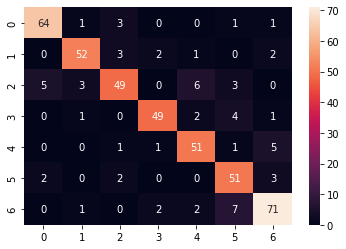

In [ ]:
y_preds = m_model1.predict(x_T_test)
y_hat = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_T_test, axis=1)

cm = confusion_matrix(y_true, y_hat)

sum = 0

for i in range(cm.shape[0]):
  sum += cm[i,i]

print(len(y_preds))
print(sum / len(y_preds))
print(f1_score(y_true, y_hat, average='weighted'))
sns.heatmap(cm, annot=True)

453
0.9139072847682119
0.9141970610561828


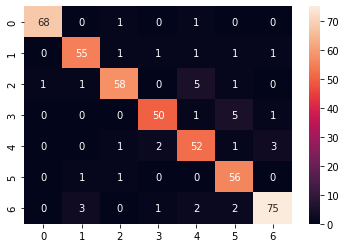

In [ ]:
y1_preds = m_model1.predict(x_MFCC_test)
y2_preds = model1.predict(x_MEL_test)
y_preds = y1_preds + y2_preds
y_hat = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_T_test, axis=1)

cm = confusion_matrix(y_true, y_hat)

sum = 0

for i in range(cm.shape[0]):
  sum += cm[i,i]

print(len(y_preds))
print(sum / len(y_preds))
print(f1_score(y_true, y_hat, average='weighted'))
sns.heatmap(cm, annot=True)